# **(DATA CLEANING)**

## Objectives

* Handle/Evaluate missing data.
* Cleaning data

## Inputs

* outputs/datasets/collection/HousePrices.csv 

## Outputs

* Generate cleaned data in outputs/datasets/cleaned 
 

## Additional Comments

* Handle missing data and droping variables


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Housepriceissues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Housepriceissues'

---

# Load Data

Loading collected data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# Data Exploration

We want to check the shapes, length and distrubution on the data when cleaning it.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
len(vars_with_missing_data)

10

In [ ]:
df[vars_with_missing_data].info()

In [7]:
# Code from walkthrough project 02
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("No variables has missing data")

/tmp/ipykernel_980/1322902114.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Data Cleaning

### Assessing Missing Data Levels

In [8]:
def AssessMissingValues(df):
    """
    This function assesses the presence of missing values in a DataFrame.
    """
    # Calculate the absolute number of missing values per column
    total_missing = df.isna().sum()

    # Calculate the percentage of missing values relative to the total rows
    percent_missing = (total_missing / len(df) * 100).round(2)

    # Create a new DataFrame to display missing data stats
    missing_stats = pd.DataFrame({
        'MissingValuesCount': total_missing,
        'PercentOfTotal': percent_missing,
        'ColumnType': df.dtypes
    }).sort_values(by='PercentOfTotal', ascending=False)

    # Filter to include only columns with missing values
    missing_stats = missing_stats[missing_stats['PercentOfTotal'] > 0]

    return missing_stats



In [9]:
AssessMissingValues(df)

,MissingValuesCount,PercentOfTotal,ColumnType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


We can drop the variables with data that wont have big inpact on the predictions


### Handle Missing Data

Inpiered off code insitutes learning material and https://github.com/Amareteklay/heritage-housing-issues/blob/main/jupyter_notebooks/02%20-%20Data_Cleaning.ipynb

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
%matplotlib inline

sns.set(style="whitegrid")

def VisualizeDataCleaningImpact(df_original, df_cleaned, applied_methods_vars):
    flag_count = 1  # To keep track of the plot sequence
    
    # Identify categorical variables from the original dataset
    cat_vars = df_original.select_dtypes(include=['object', 'category']).columns
    
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{applied_methods_vars} \n\n")

    for var in applied_methods_vars:
        if var in cat_vars:  # For categorical variables, use bar plot
            df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
            df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
            df_combined = pd.concat([df1, df2], axis=0)
            
            plt.figure(figsize=(15, 5))
            sns.countplot(x="Value", hue='Type', data=df_combined, palette=['#432371', '#FAAE7B'])
            plt.title(f"Bar Plot {flag_count}: {var}")
            plt.xticks(rotation=90)
            plt.legend()

        else:  # For numerical variables, use KDE plot
            plt.figure(figsize=(10, 5))
            sns.histplot(df_original[var].dropna(), color="#432371", label='Original', alpha=0.5, edgecolor='black', zorder=1, kde=True)
            sns.histplot(df_cleaned[var].dropna(), color="#FAAE7B", label='Cleaned', alpha=0.5, edgecolor='black', zorder=1, kde=True)
            #sns.kdeplot(df_original[var].dropna(), color="#432371", label='Original', zorder=2)
            #sns.kdeplot(df_cleaned[var].dropna(), color="#FAAE7B", label='Cleaned', zorder=2)
            plt.title(f"KDE Plot {flag_count}: {var}")
            plt.legend()
            plt.show()

        flag_count += 1


### Data cleaning Summary

* Exclusion of Specific Features: We have decided to remove the columns 'EnclosedPorch' and 'WoodDeckSF'. Despite their potential relevance in augmenting a property's size, their high rate of missing values (exceeding 80%) undermines their utility for predictive modeling. The lack of substantial data variation in these columns across different house price levels supports their exclusion from our analysis.

* Approaches for Imputation:

* a. Mean Imputation Application: For the columns 'LotFrontage' and 'BedroomAbvGr', we will apply mean imputation. This choice is grounded in the observation that their distribution patterns are relatively symmetrical, resembling a normal distribution. Substituting missing values with the mean will maintain the central tendency of these features.

* b. Median Imputation Utilization: The features '2ndFlrSF', 'GarageYrBlt', and 'MasVnrArea' will undergo median imputation. Despite these features being somewhat normally distributed, the presence of skewed data warrants the use of the median. This approach is preferred over the mean, as it is less susceptible to distortion by outliers, providing a more robust measure of central tendency.

* c. Categorical Imputation for Specific Features: For 'GarageFinish' and 'BsmtFinType1', categorical imputation is the chosen method. As these are categorical variables, employing a MeanMedian imputation approach is infeasible. Instead, we will replace missing values with the most frequently occurring category within each respective feature.

* This tailored approach to handling missing data aligns with the specific characteristics of each variable in our dataset, enhancing the integrity and utility of the cleaned data for subsequent analysis and modeling.

### Train Set And Test Set

In [11]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [12]:
df_data_missing = AssessMissingValues(TrainSet)
print(f"* Total variables affected by missing data: {df_data_missing.shape[0]} \n")
df_data_missing

* Total variables affected by missing data: 10 



,MissingValuesCount,PercentOfTotal,ColumnType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,184,15.75,object
BsmtFinType1,114,9.76,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
BsmtExposure,28,2.40,object
MasVnrArea,6,0.51,float64


### Drop variables 

* Variable Removal: Initially, the code specifies a list of variables, 'EnclosedPorch' and 'WoodDeckSF', which are identified for removal from the dataset. This is done in anticipation that dropping these variables, due to their high rate of missing data, will refine the dataset for better analysis and modeling.

* Feature Dropping and Confirmation: The DropFeatures class from the feature_engine.selection module is then utilized to execute the removal of these specified variables from the training dataset (TrainSet). After this operation, the code conducts a verification check to ensure that each of the intended variables has indeed been dropped from the DataFrame. This verification is presented through a series of print statements that confirm the absence of each variable in the updated DataFrame.



In [13]:
# Applying feature removal process
from feature_engine.selection import DropFeatures

# Specifying the variables to be excluded
drop_columns = ['EnclosedPorch', 'WoodDeckSF']
feature_dropper = DropFeatures(features_to_drop=drop_columns)
df_updated = feature_dropper.fit_transform(TrainSet)

# Checking if the specified columns have been successfully removed
for column in drop_columns:
    print(f"Is '{column}' present in the updated DataFrame? {'Yes' if column in df_updated.columns else 'No'}")

Is 'EnclosedPorch' present in the updated DataFrame? No
Is 'WoodDeckSF' present in the updated DataFrame? No



* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr'] 




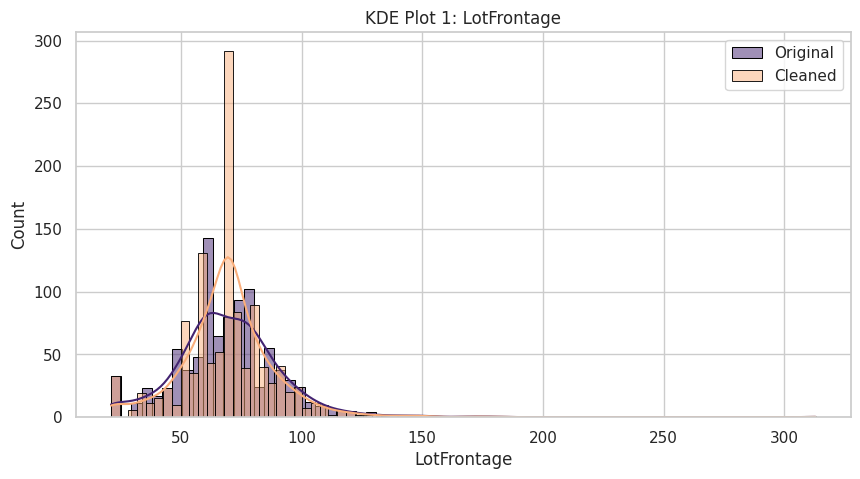

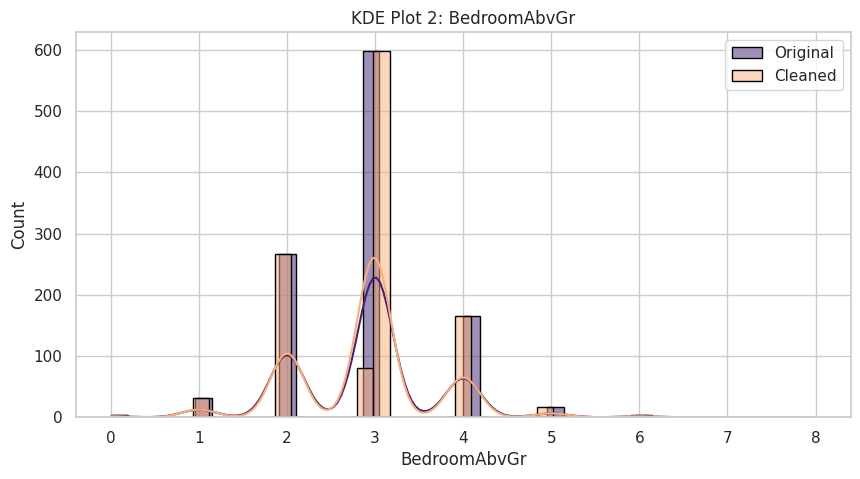

In [14]:
# Applying Mean Imputation to specified variables
from feature_engine.imputation import MeanMedianImputer

# Implementing Mean Imputation
mean_impute_vars = ['LotFrontage', 'BedroomAbvGr']
mean_imputer = MeanMedianImputer(imputation_method='mean', variables=mean_impute_vars)
df_imputed = mean_imputer.fit_transform(TrainSet)

# Visualizing the impact of mean imputation on the data
VisualizeDataCleaningImpact(df_original=TrainSet, df_cleaned=df_imputed, applied_methods_vars=mean_impute_vars)

### Median Imputation

* This code snippet demonstrates the process of median imputation for handling missing values in a dataset. It specifically targets three variables: '2ndFlrSF', 'GarageYrBlt', and 'MasVnrArea'. The MeanMedianImputer from the feature_engine.imputation library is utilized, configured for median imputation. After applying this imputation method to the TrainSet, the impact of this data cleaning step is visualized through the VisualizeDataCleaningImpact function. This function compares the original dataset with the cleaned version, highlighting changes in data distribution for the specified variables.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




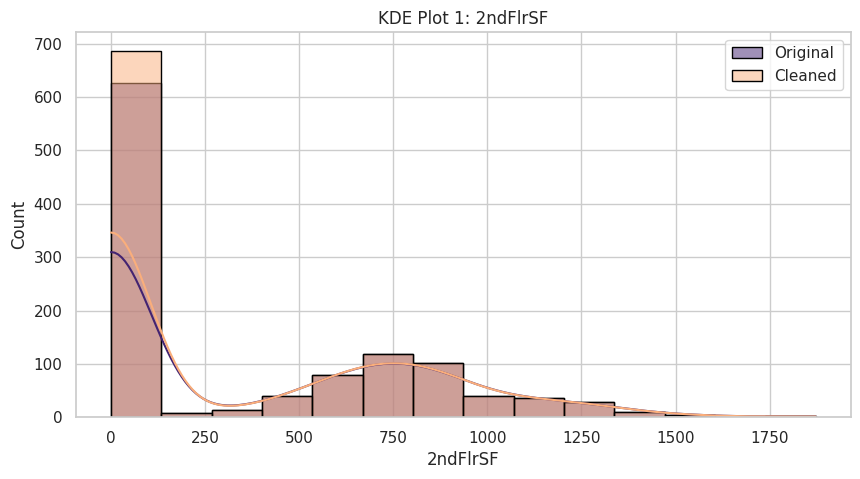

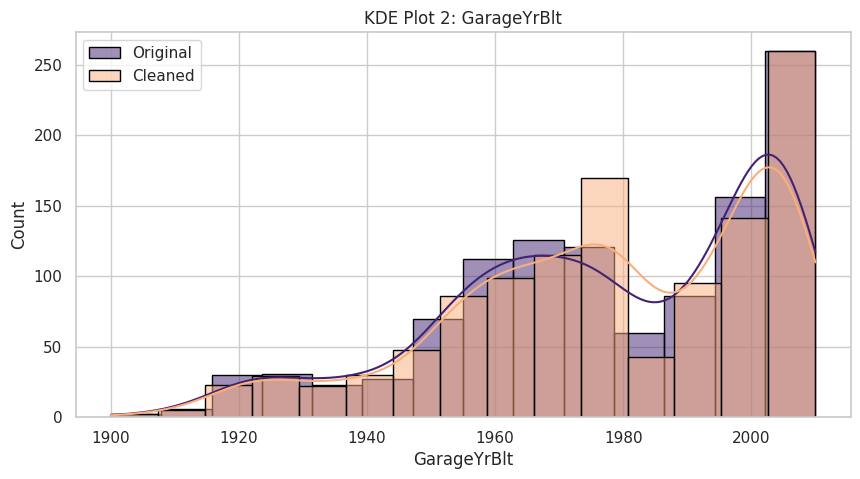

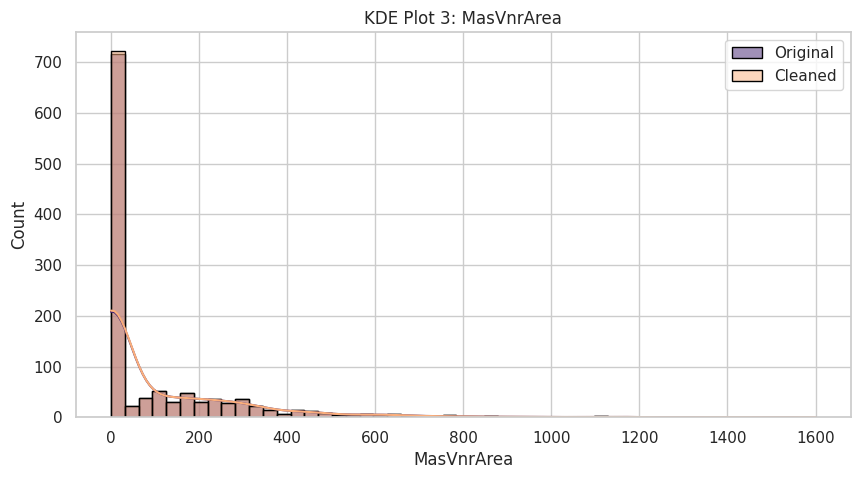

In [15]:
from feature_engine.imputation import MeanMedianImputer

# Specifying the variables for median imputation
median_impute_vars = ['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
median_imputer = MeanMedianImputer(imputation_method='median', variables=median_impute_vars)
df_median_imputed = median_imputer.fit_transform(TrainSet)

# Visualizing the impact of median imputation on the data
VisualizeDataCleaningImpact(df_original=TrainSet, df_cleaned=df_median_imputed, applied_methods_vars=median_impute_vars)

In [16]:
TrainSet[(TrainSet['GarageArea'] ==0)][['GarageYrBlt', 'GarageArea']]

,GarageYrBlt,GarageArea
431,NaN,0
638,NaN,0
1337,NaN,0
528,NaN,0
960,NaN,0
1011,NaN,0
1283,NaN,0
1038,NaN,0
165,NaN,0
1349,NaN,0


* Shows where the var are 0

### Categorical Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1', 'BsmtExposure'] 




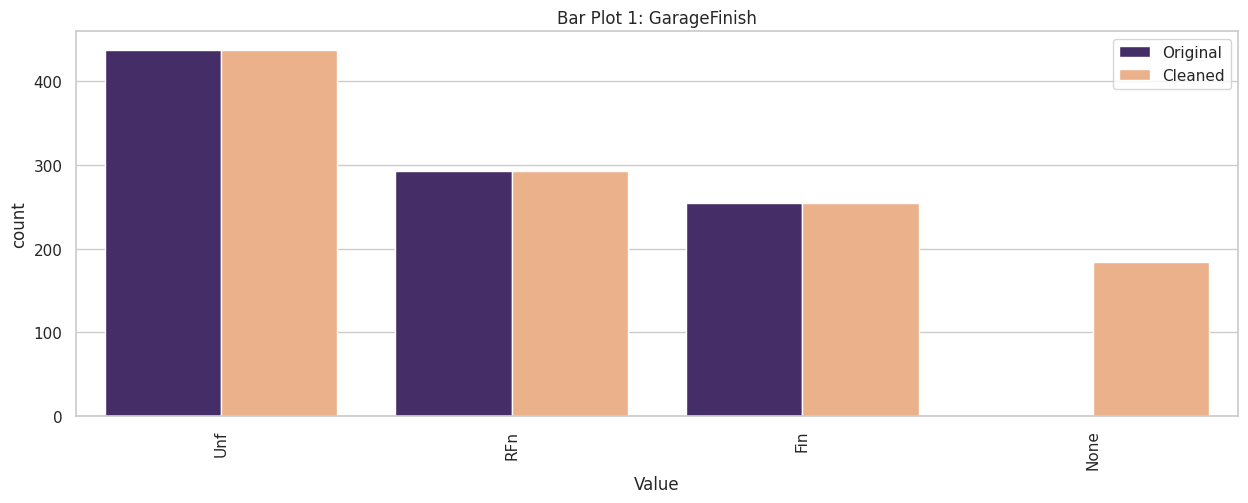

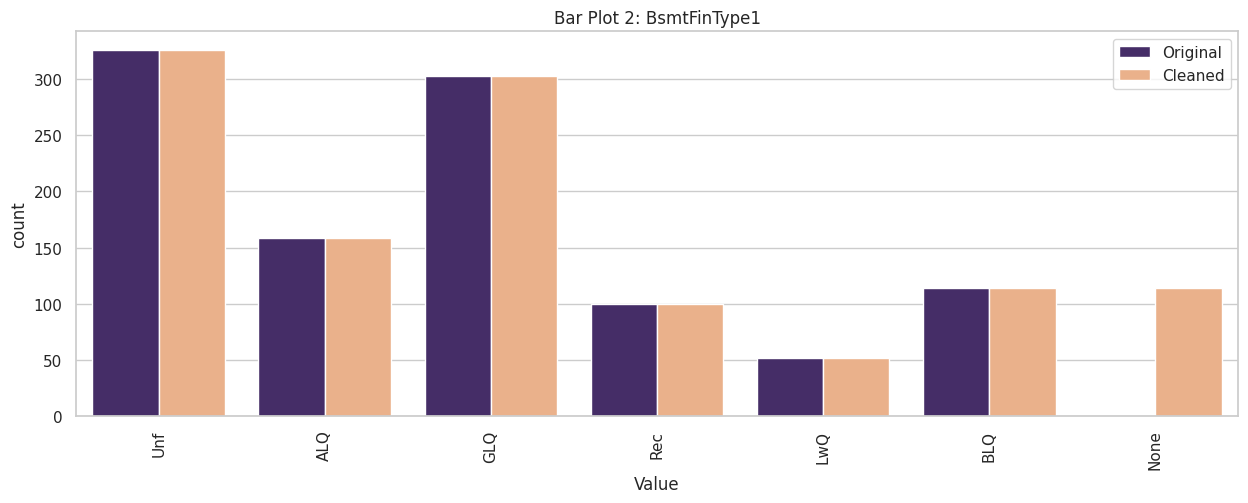

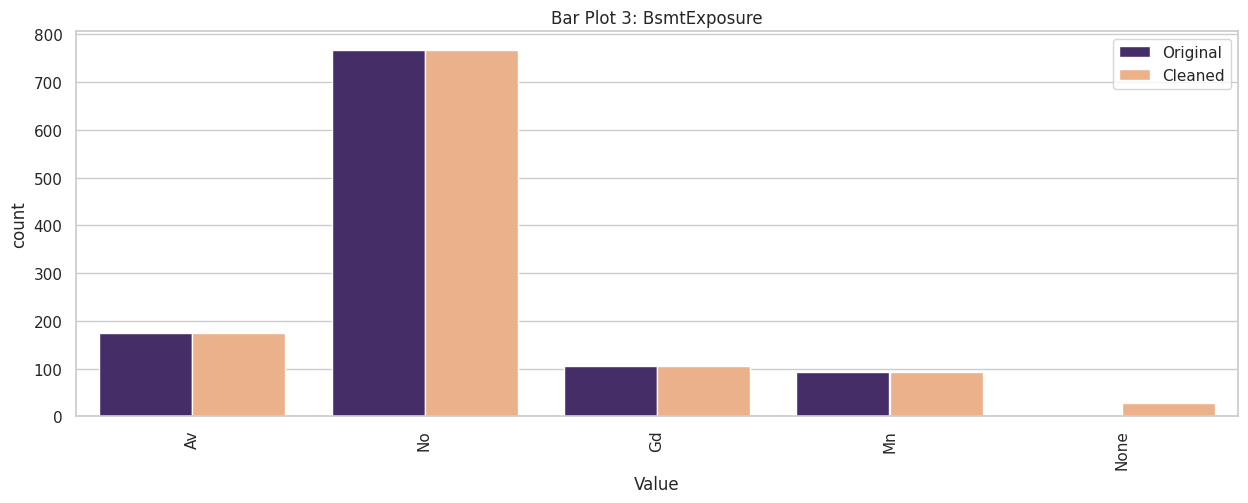

In [17]:
from feature_engine.imputation import CategoricalImputer

categorical_vars = ['GarageFinish', 'BsmtFinType1', 'BsmtExposure']
imputer = CategoricalImputer(imputation_method='missing', fill_value='None', variables=categorical_vars)
df_cat_imputation = imputer.fit_transform(TrainSet)
VisualizeDataCleaningImpact(df_original=TrainSet,
                            df_cleaned=df_cat_imputation,
                            applied_methods_vars=categorical_vars)

In [18]:
TrainSet[(TrainSet['GarageArea'] ==0)][['GarageFinish', 'GarageArea']]

,GarageFinish,GarageArea
431,NaN,0
638,NaN,0
1337,NaN,0
528,NaN,0
960,NaN,0
1011,NaN,0
1283,NaN,0
1038,NaN,0
165,NaN,0
1349,NaN,0


---

### Data Cleaning Pipeline

* Mean Imputation: This step uses the MeanMedianImputer class with imputation_method='mean' to impute missing values in the 'LotFrontage' and 'BedroomAbvGr' columns using their respective means. This is suitable for continuous variables where the mean is a good estimate of central tendency.

* Median Imputation: Also utilizing the MeanMedianImputer class but with imputation_method='median', this step addresses missing values in the '2ndFlrSF' and 'MasVnrArea' columns by replacing them with the median of each column. This method is often used for skewed distributions or when the median is a more robust measure than the mean.

* Categorical Imputation: The CategoricalImputer class, set to imputation_method='frequent', is used for the 'GarageFinish' and 'BsmtFinType1' columns. It replaces missing values with the most frequent category within each column. This approach is common for categorical variables where the mode (or most frequent category) is a logical choice for imputation.

* Dropping Variables: The final step uses the DropFeatures class to remove specific columns from the dataset. In this case, 'EnclosedPorch', 'GarageYrBlt', and 'WoodDeckSF' are dropped. This step is crucial for eliminating features that are not useful for the analysis or modeling process.

* Overall, this pipeline is a structured approach to clean and prepare the data for further analysis or modeling, enhancing the quality and utility of the dataset.

In [19]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.selection import DropFeatures

# Define a structured data preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('impute_mean', MeanMedianImputer(imputation_method='mean', 
                                      variables=['LotFrontage', 'BedroomAbvGr'])),
    ('impute_median', MeanMedianImputer(imputation_method='median', 
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
    ('impute_categorical', CategoricalImputer(imputation_method='frequent', 
                                              variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),
    ('drop_features', DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF']))
])

* After this we apply the dataset to the whole dataset. We do it to get cleaned data.

In [20]:
TrainSet, TestSet = preprocessing_pipeline.fit_transform(TrainSet) , preprocessing_pipeline.fit_transform(TestSet)

In [21]:
df = preprocessing_pipeline.fit_transform(df)

In [22]:
AssessMissingValues(TestSet)

,MissingValuesCount,PercentOfTotal,ColumnType


In [23]:
AssessMissingValues(TrainSet)

,MissingValuesCount,PercentOfTotal,ColumnType


In [24]:
AssessMissingValues(df)

,MissingValuesCount,PercentOfTotal,ColumnType


* By running this we see that there is no missing data to handle 

---

# Push files to Repo

* We make an directory for the cleaned data files.

In [25]:
import os

try:
    os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
    print(f"An error occurred: {e}")

### Train Set

In [26]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [27]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

### Cleaned Dataset

In [28]:
df.to_csv("outputs/datasets/cleaned/HousePricesCleaned.csv", index=False)

### Data Cleaning Pipeline

In [29]:
import joblib

file_path = f'outputs/ml_pipeline/data_cleaning'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [31]:
joblib.dump(value=preprocessing_pipeline, filename=f"{file_path}/preprocessing_pipeline.pkl")


['outputs/ml_pipeline/data_cleaning/preprocessing_pipeline.pkl']